In [2]:
import pandas as pd
df = pd.read_csv("masptop50.csv")
df.tail()

,Price,Close,High,Low,Open,Volume
938,2025-07-09,60.2599983215332,60.2599983215332,58.79999923706055,59.88999938964844,839268
939,2025-07-10,57.20000076293945,60.06999969482422,55.81999969482422,60.06999969482422,1909772
940,2025-07-11,57.040000915527344,58.630001068115234,56.29999923706055,58.630001068115234,643833
941,2025-07-14,56.09000015258789,57.5,55.52000045776367,57.5,869492
942,2025-07-15,57.189998626708984,57.4900016784668,56.29999923706055,57.4900016784668,262741


In [12]:
# Step 1: Remove rows where Volume is 0
df = df[df['Volume'] != 0]

# Step 2: Drop any rows with NaN values
df.dropna(inplace=True)

# Step 3: Check if everything is clean
print(df.isna().sum())



Price     0
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64


In [22]:
#Check if any zero volumes are available
indexZeros = df[ df['Volume'] == 0 ].index

df.drop(indexZeros , inplace=True)
df.loc[(df["Volume"] == 0 )]
df.isna().sum()

Price     0
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64

In [34]:
import numpy as np
import pandas_ta as ta
#df.ta.indicators()
#help(ta.atr)
df['ATR'] = df.ta.atr(length=20)
df['RSI'] = df.ta.rsi()
df['Average'] = df.ta.midprice(length=1) #midprice
df['MA40'] = df.ta.sma(length=40)
df['MA80'] = df.ta.sma(length=80)
df['MA160'] = df.ta.sma(length=160)

from scipy.stats import linregress
def get_slope(array):
    y = np.array(array)
    x = np.arange(len(y))
    slope, intercept, r_value, p_value, std_err = linregress(x,y)
    return slope

#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
backrollingN = 6
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
df['slopeMA40'] = df['MA40'].rolling(window=backrollingN).apply(get_slope, raw=True)
df['slopeMA80'] = df['MA80'].rolling(window=backrollingN).apply(get_slope, raw=True)
df['slopeMA160'] = df['MA160'].rolling(window=backrollingN).apply(get_slope, raw=True)
df['AverageSlope'] = df['Average'].rolling(window=backrollingN).apply(get_slope, raw=True)
df['RSISlope'] = df['RSI'].rolling(window=backrollingN).apply(get_slope, raw=True)

In [38]:
df.tail()

,Price,Close,High,Low,Open,Volume,ATR,RSI,Average,MA40,MA80,MA160,slopeMA40,slopeMA160,slopeMA80,AverageSlope,RSISlope
938,NaN,60.259998,60.259998,58.799999,59.889999,839268.0,1.698286,83.212689,59.529999,54.94300,52.26250,54.677437,0.121743,0.038291,0.077771,0.801143,4.870310
939,NaN,57.200001,60.070000,55.820000,60.070000,1909772.0,1.835372,58.454943,57.945000,55.00475,52.40400,54.726062,0.115729,0.045596,0.107325,0.737143,0.846535
940,NaN,57.040001,58.630001,56.299999,58.630001,643833.0,1.860103,57.491757,57.465000,55.03675,52.53625,54.767562,0.099150,0.052512,0.127486,0.290428,-2.767299
941,NaN,56.090000,57.500000,55.520000,57.500000,869492.0,1.866098,52.011768,56.510000,55.05625,52.63975,54.786812,0.074864,0.048982,0.132075,-0.152572,-6.004116
942,NaN,57.189999,57.490002,56.299999,57.490002,262741.0,1.842793,57.109616,56.895000,55.12275,52.75700,54.809750,0.055336,0.039480,0.127704,-0.398286,-5.876940


In [52]:
#Target flexible way
pipdiff = 500*1e-5 #for TP
SLTPRatio = 2 #pipdiff/Ratio gives SL

def mytarget(barsupfront, df1):
    length = len(df1)
    High = list(df1['High'])
    Low = list(df1['Low'])
    Close = list(df1['Close'])
    Open = list(df1['Open'])
    trendcat = [None] * length
    
    for line in range (0,length-barsupfront-2):
        valueOpenLow = 0
        valueOpenHigh = 0
        for i in range(1,barsupfront+2):
            value1 = Open[line+1]-Low[line+i]
            value2 = Open[line+1]-High[line+i]
            valueOpenLow = max(value1, valueOpenLow)
            valueOpenHigh = min(value2, valueOpenHigh)

            if ( (valueOpenLow >= pipdiff) and (-valueOpenHigh <= (pipdiff/SLTPRatio)) ):
                trendcat[line] = 1 #-1 downtrend
                break
            elif ( (valueOpenLow <= (pipdiff/SLTPRatio)) and (-valueOpenHigh >= pipdiff) ):
                trendcat[line] = 2 # uptrend
                break
            else:
                trendcat[line] = 0 # no clear trend
            
    return trendcat

In [54]:
# mytarget(barsfront to take into account, dataframe)
df['mytarget'] = mytarget(16, df)
df.head()

,Price,Close,High,Low,Open,Volume,ATR,RSI,Average,MA40,MA80,MA160,slopeMA40,slopeMA160,slopeMA80,AverageSlope,RSISlope,mytarget
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,NaN,28.040001,28.320000,27.650000,28.219999,486265.0,NaN,NaN,27.985,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,NaN,28.280001,28.750000,28.049999,28.600000,172502.0,NaN,NaN,28.400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,NaN,27.990000,30.100000,27.900000,28.549999,526085.0,NaN,NaN,29.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
5,NaN,27.719999,28.940001,27.299999,28.940001,134730.0,NaN,NaN,28.120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


C:\Users\shiva\AppData\Local\Temp\ipykernel_4176\532070288.py:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_model.hist(ax = ax)


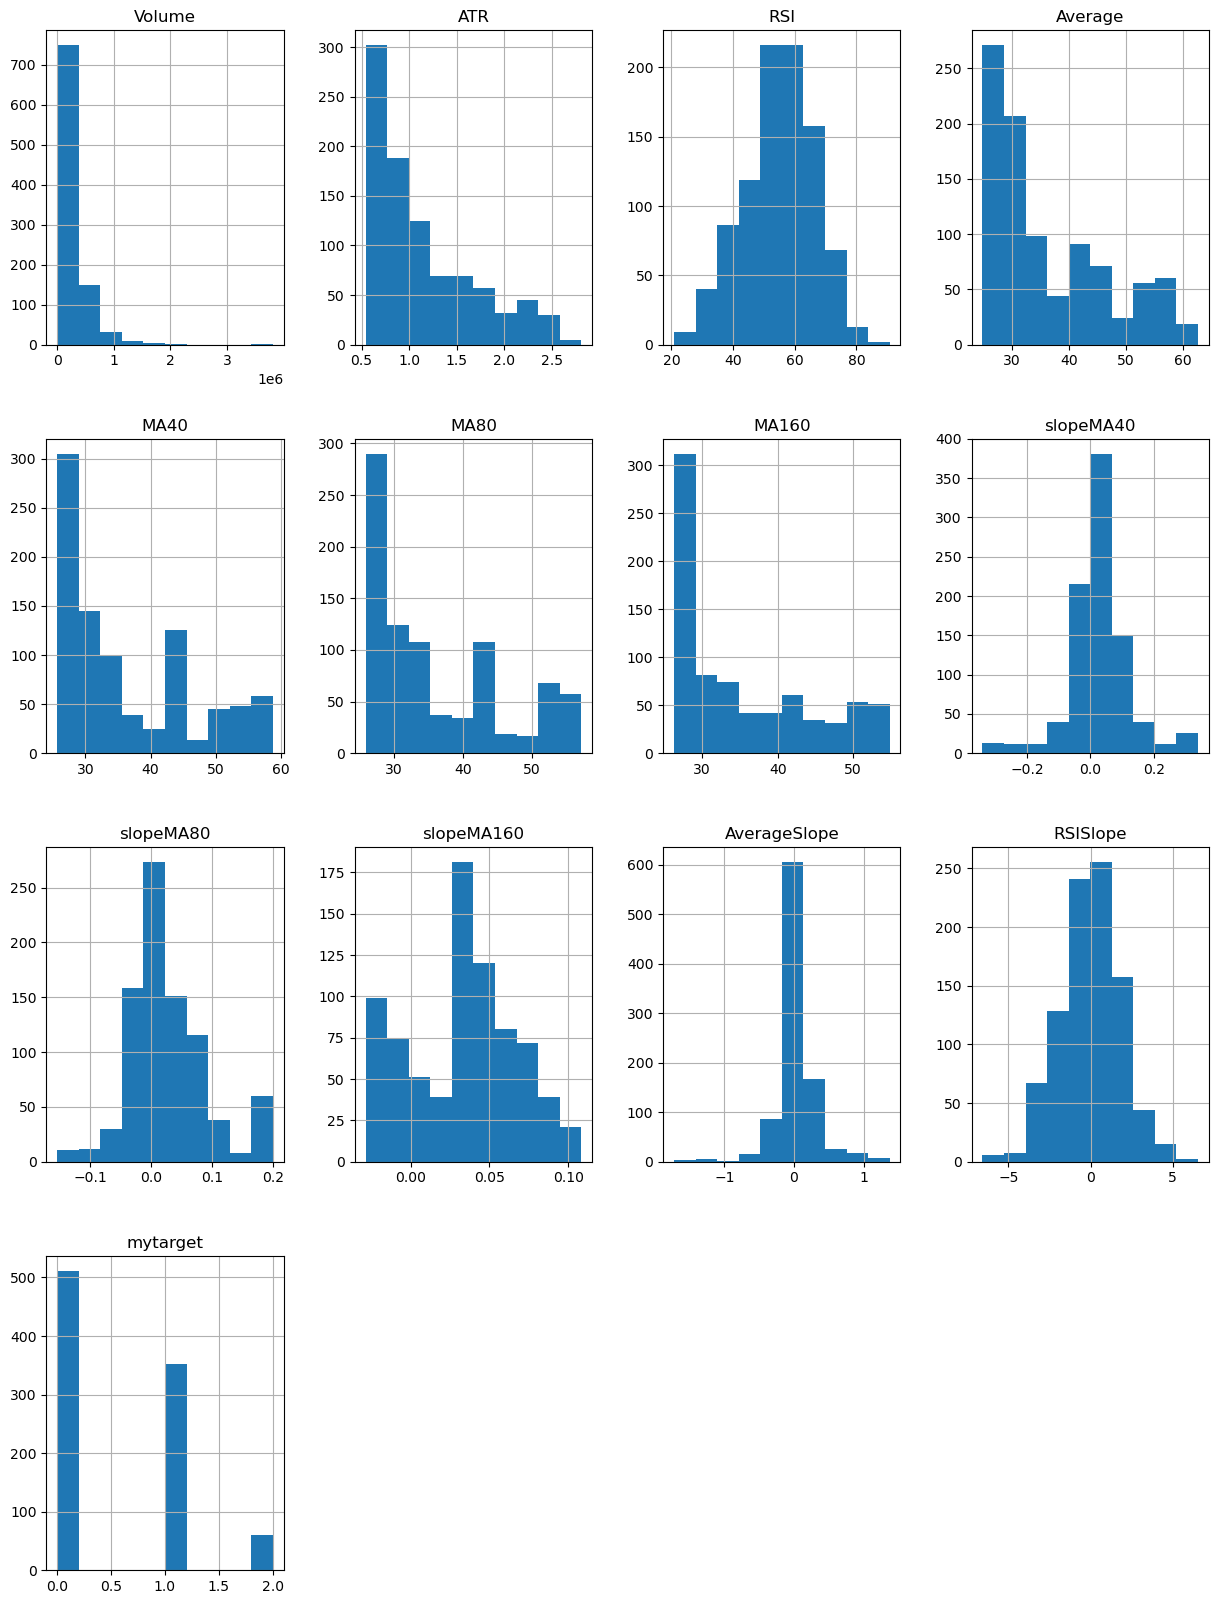

In [58]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
df_model= df[['Volume', 'ATR', 'RSI', 'Average', 'MA40', 'MA80', 'MA160', 'slopeMA40', 'slopeMA80', 'slopeMA160', 'AverageSlope', 'RSISlope', 'mytarget']] 
df_model.hist(ax = ax)
plt.show()

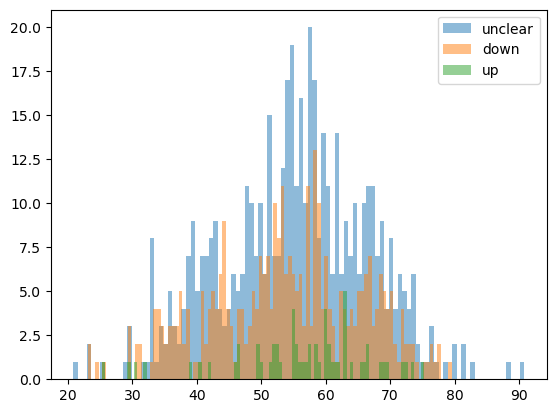

In [60]:
from matplotlib import pyplot
df_up=df.RSI[ df['mytarget'] == 2 ]
df_down=df.RSI[ df['mytarget'] == 1 ]
df_unclear=df.RSI[ df['mytarget'] == 0 ]
pyplot.hist(df_unclear, bins=100, alpha=0.5, label='unclear')
pyplot.hist(df_down, bins=100, alpha=0.5, label='down')
pyplot.hist(df_up, bins=100, alpha=0.5, label='up')

pyplot.legend(loc='upper right')
pyplot.show()

In [62]:
df_model=df_model.dropna()

attributes=['ATR', 'RSI', 'Average', 'MA40', 'MA80', 'MA160', 'slopeMA40', 'slopeMA80', 'slopeMA160', 'AverageSlope', 'RSISlope']
X = df_model[attributes]
y = df_model["mytarget"]

print(X)

          ATR        RSI    Average      MA40       MA80      MA160  \
166  1.973048  31.391573  27.620000  27.95075  28.209125  28.995375   
167  1.907882  35.588854  25.845000  27.85850  28.181500  28.987250   
168  1.866980  43.516844  26.490000  27.76000  28.160000  28.979500   
169  1.847128  52.073627  27.185000  27.68125  28.137375  28.976688   
170  1.810765  51.437866  27.420000  27.59625  28.108250  28.973250   
..        ...        ...        ...       ...        ...        ...   
920  1.598424  54.277140  53.705000  52.77800  52.635500  53.740062   
921  1.588003  58.238507  54.494999  52.97375  52.575875  53.804500   
922  1.601603  56.051523  55.250000  53.16025  52.514750  53.865250   
923  1.602022  55.660046  55.135000  53.34100  52.443875  53.927125   
924  1.607921  51.766507  54.029999  53.48850  52.368500  53.984312   

     slopeMA40  slopeMA80  slopeMA160  AverageSlope  RSISlope  
166  -0.084529  -0.037918   -0.013479      0.301429 -0.743742  
167  -0.088293  -0.

In [64]:
from sklearn.model_selection import train_test_split

In [75]:
from sklearn.neighbors import KNeighborsClassifier

# Reduce n_neighbors to be less than or equal to the number of samples in the training set
# Since you have 80 samples, n_neighbors should be <= 80
model = KNeighborsClassifier(
    n_neighbors=5,  # Changed from 200 to a smaller value (5 is a common default)
    weights='uniform', 
    algorithm='kd_tree', 
    leaf_size=30, 
    p=1, 
    metric='minkowski', 
    metric_params=None, 
    n_jobs=1
)
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

In [77]:
from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)
print("Accuracy train: %.2f%%" % (accuracy_train * 100.0))
print("Accuracy test: %.2f%%" % (accuracy_test * 100.0))

#------------------------------------------------------------------
#--- How should I compare my accuracy ?
print(df_model['mytarget'].value_counts()*100/df_model['mytarget'].count())

# Random Model, gambler?
pred_test = np.random.choice([0, 1, 2], len(y_pred_test))
accuracy_test = accuracy_score(y_test, pred_test)
print("Accuracy Gambler: %.2f%%" % (accuracy_test * 100.0))

Accuracy train: 73.75%
Accuracy test: 50.00%
mytarget
0.0    59.683794
1.0    33.333333
2.0     6.982872
Name: count, dtype: float64
Accuracy Gambler: 25.00%


In [82]:
# First, install the xgboost package
!pip install xgboost

# Then import the required libraries
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score  # Adding this import as it's needed for accuracy_score

# Now you can use XGBoost
model = XGBClassifier()
model.fit(X_train, y_train)
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)
acc_train = accuracy_score(y_train, pred_train)
acc_test = accuracy_score(y_test, pred_test)
print('****Train Results****')
print("Accuracy: {:.4%}".format(acc_train))
print('****Test Results****')
print("Accuracy: {:.4%}".format(acc_test))

****Train Results****
Accuracy: 100.0000%
****Test Results****
Accuracy: 60.0000%


In [84]:
#random sampling
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

#sequential sampling
train_index = int(0.8 * len(X))
X_train, X_test = X[:train_index], X[train_index:]
y_train, y_test = y[:train_index], y[train_index:]

model = XGBClassifier()
model.fit(X_train, y_train)
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)
acc_train = accuracy_score(y_train, pred_train)
acc_test = accuracy_score(y_test, pred_test)
print('****Train Results****')
print("Accuracy: {:.4%}".format(acc_train))
print('****Test Results****')
print("Accuracy: {:.4%}".format(acc_test))

****Train Results****
Accuracy: 100.0000%
****Test Results****
Accuracy: 50.0000%


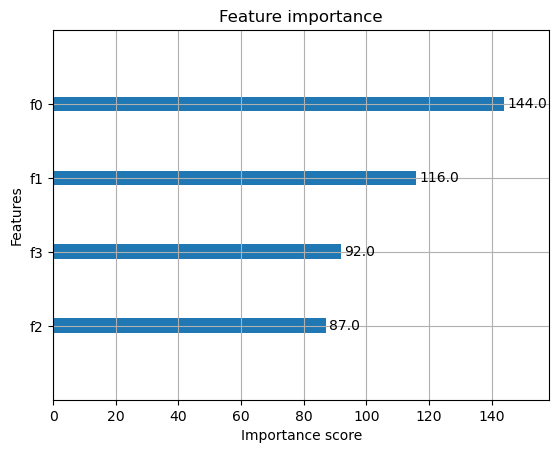

In [88]:
from matplotlib import pyplot
from xgboost import plot_importance
#plot feature importance
plot_importance(model)
pyplot.show()